In [ ]:
# Miscellaneous testing for Eric - others please do not edit - git doesn't play nice with jupyter notebooks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os, sys
import torch
import optuna
import ruamel.yaml as yaml
import re

In [ ]:

path = "../active/outputs/test/move_data.csv"
results = pd.read_csv(path,index_col=0)
results["cumulative_reward"] = results.reward.cumsum()
fig = plt.figure(constrained_layout=False,figsize=(13,6))
ax=sns.lineplot(data=results,x=results.index, y = "cumulative_reward")
ax2 = plt.twinx()
sns.lineplot(data=results.epsilon, color="b", ax=ax2)

path2 = "../active/outputs/test/episode_data.csv"
episode_results = pd.read_csv(path2,index_col=0)
fig2 = plt.figure(constrained_layout=False,figsize=(13,6))
ax3 = sns.lineplot(data=episode_results,x=episode_results.index, y = episode_results.rolling(10).mean().reward)

path3 = "../active/outputs/test/loss_data.csv"
loss_results = pd.read_csv(path3,index_col=0)
fig3 = plt.figure(constrained_layout=False,figsize=(13,6))
ax4 = sns.lineplot(data=loss_results,x=loss_results.index, y = loss_results.loss)

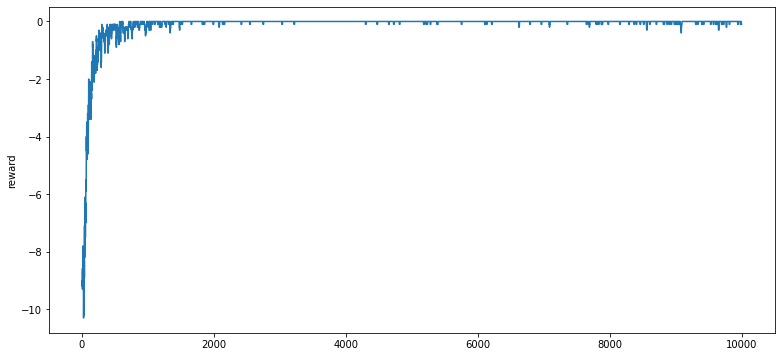

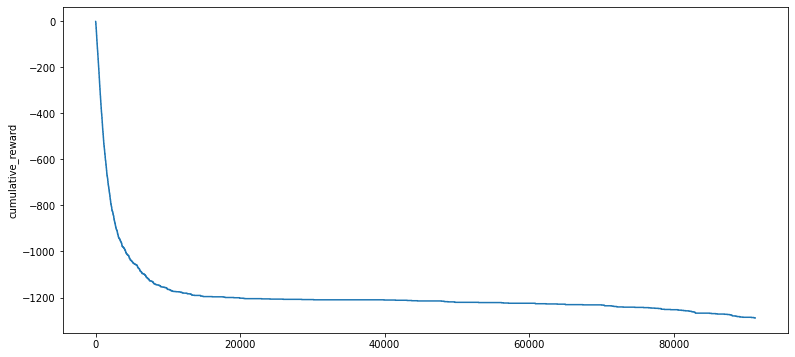

In [13]:
# Multi run results
#path = "../active/outputs/test/other_clockwiseTwoFree"
#path = "../active/outputs/test/other_clockwiseTwoFreeAlt"
#path = "../active/outputs/test/other_clockwiseZeroStart"
#path = "../active/outputs/test/other_1_1_shape_4m"
path = "../active/outputs/test/other_1_2_shape_4m"

fig = plt.figure(constrained_layout=False,figsize=(13,6))
for i in np.arange(0,1):
    run_path = path + "/"+str(i)+"/episode_data.csv"
    episode_results = pd.read_csv(run_path,index_col=0)
    sns.lineplot(data=episode_results,x=episode_results.index, y = episode_results.rolling(10).mean().reward)
fig2= plt.figure(constrained_layout=False,figsize=(13,6))
for i in np.arange(0,1):
    run_path = path + "/"+str(i)+"/move_data.csv"
    results = pd.read_csv(run_path,index_col=0)
    results["cumulative_reward"] = results.reward.cumsum()
    sns.lineplot(data=results,x=results.index, y = "cumulative_reward")

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [ ]:
study_name = "naive_n8_Rule_001_8reps"
storage_name = "sqlite:///../active/outputs/tuning/{}.db".format(study_name)
study = optuna.study.load_study(study_name=study_name,storage=storage_name)

In [ ]:
study.best_params

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_contour(study)

In [ ]:
#import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split


In [ ]:
plot_param_importances(study)

In [ ]:
#print(np.ravel_multi_index((o_row,o_col,b_index),(6,6,4)))
print(np.unravel_index(72, (6,6,4)))

In [2]:
class SafeLoaderIgnoreUnknown(yaml.SafeLoader):
    def ignore_unknown(self, node):
        return None 

SafeLoaderIgnoreUnknown.add_constructor(None, SafeLoaderIgnoreUnknown.ignore_unknown)

In [42]:
# Location of rule runs
rule_runs_path = "/Users/eric/repos/gohr/active/outputs/rule_runs/"
runs_to_analyze = ["initial_run_naive_n2","initial_run_naive_n4","initial_run_naive_n6","initial_run_naive_n8","initial_run_n2","initial_run_n4","initial_run_n6","initial_run_n8"]
#runs_to_analyze = ["misc_initial_run_naive_sparse_n2","misc_initial_run_naive_dense_n2","initial_run_n8","initial_run_naive_n8"]
#runs_to_analyze=["initial_run_n8","initial_run_naive_n8"]
#loader = yaml.SafeLoader
# loader.add_implicit_resolver(
# u'tag:yaml.org,2002:float',
# re.compile(u'''^(?:
#     [-+]?(?:[0-9][0-9_]*)\\.[0-9_]*(?:[eE][-+]?[0-9]+)?
# |[-+]?(?:[0-9][0-9_]*)(?:[eE][-+]?[0-9]+)
# |\\.[0-9_]+(?:[eE][-+][0-9]+)?
# |[-+]?[0-9][0-9_]*(?::[0-5]?[0-9])+\\.[0-9_]*
# |[-+]?\\.(?:inf|Inf|INF)
# |\\.(?:nan|NaN|NAN))$''', re.X),
# list(u'-+0123456789.'))

# Create lists that will hold dataframes for concatenation
episode_df_list = []
move_df_list = []
terminal_results_list = []

# Loop over the specified rule runs
for run in runs_to_analyze:
    #print(run)
    # Form complete run path
    run_path = rule_runs_path+run
    #print(run_path)
    # Get the experiments for that run (each one is a set of trials for a particular rule)
    experiments = [name for name in os.listdir(run_path) if name!=".DS_Store"]
    #print(experiments)
    # Loop over the experiments
    for experiment in experiments:
        # Get the neptune id
        neptune_trial = experiment.split("_")[0]
        # String length may vary
        trial_str_length = len(neptune_trial)
        # Rule is everything after the neptune id and an _ character
        rule_name = experiment[trial_str_length+1:]
        #print(neptune_trial)
        #print(rule_name)
        # For complete experiment path
        experiment_path = os.path.join(run_path,experiment)
        #print(experiment_path)
        trials = [name for name in os.listdir(experiment_path) if name!=".DS_Store"]
        if not(len(trials)==56):
            print(run, experiment, len(trials))
        #print(trials)
        for trial in trials:
            trial_path = os.path.join(experiment_path,trial)
            # Get parameters
            yaml_path = os.path.join(trial_path,"data.yaml")
            with open(yaml_path, 'r') as param_file:
                args = yaml.load(param_file, Loader=SafeLoaderIgnoreUnknown)
                featurization =args["FEATURIZATION"]
            # Import episodic data and process relevant columns
            episodic_data_path = os.path.join(trial_path,"episode_data.csv")
            trial_results = pd.read_csv(episodic_data_path,index_col=0)
            trial_results["rule"]=rule_name
            trial_results["params"]=run
            trial_results["memory"]=int(run[-1])
            trial_results["experiment_id"]=neptune_trial
            trial_results["trial"]=trial
            trial_results["featurization"]=featurization
            trial_results["ep_error"]=-1*trial_results["reward"]
            trial_results["cumulative_error"] = trial_results.ep_error.cumsum()
            terminal_results_list.append(trial_results.iloc[-1].to_frame().transpose())
            test_ser = trial_results.iloc[-1]
            episode_df_list.append(trial_results)

# Concatenate everything into one dataframe
episode_results_df = pd.concat(episode_df_list,ignore_index=True)
terminal_results_df = pd.concat(terminal_results_list,ignore_index=True)

In [48]:
np.unravel_index(0, (6,6,4))

(0, 0, 0)

In [ ]:
move_results_df.head()

In [ ]:
test = "520898985 3518358113  935519265 1996263507 3558344927 1397703365
        1295401666 1158543765 3723623990 2683537209 1307172100 3033467496
  704265400 3515439275 3113279039 1822197454 1385105505 2555572186
 2819045260  812954665 1438620776  109760696 2012545022 1983870780
  215558076 2411442034 1819374564 1474000514 3750994500 1758380786
 1992671467  727233757 2065873884 1782141230 3737790697  731438318
     931192 2810674800 3584103202 2428615279 3331682811  711756485
 1055759579  312032910 2333103018 4235275980 4172983659  131862014
 3416926178 3330251410  567567912  380561929 1004239150 4000692447
 2483165560 2638562500"

In [25]:
episode_results_df.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error
0,0,-7.0,1_2_color_4m,initial_run_naive_n2,2,GOH1-173,50,NAIVE_N,7.0,7.0
1,1,-12.0,1_2_color_4m,initial_run_naive_n2,2,GOH1-173,50,NAIVE_N,12.0,19.0
2,2,-11.0,1_2_color_4m,initial_run_naive_n2,2,GOH1-173,50,NAIVE_N,11.0,30.0
3,3,-6.0,1_2_color_4m,initial_run_naive_n2,2,GOH1-173,50,NAIVE_N,6.0,36.0
4,4,-12.0,1_2_color_4m,initial_run_naive_n2,2,GOH1-173,50,NAIVE_N,12.0,48.0


In [24]:
episode_results_df.to_csv("naive_and_sparse_episodic_data.csv")

In [40]:
test_df = pd.DataFrame(test_ser).transpose()
test_df.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error
1999,1999,0.0,1_1_color_4m,initial_run_n8,8,GOH1-243,25,NAIVE_N_DENSE,-0.0,2431.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


ValueError: Invalid RGBA argument: 'memory'

<Figure size 5616x432 with 0 Axes>

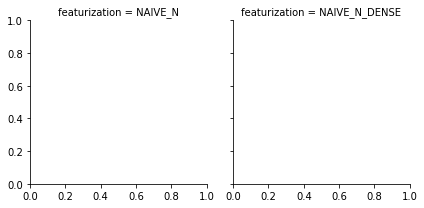

In [89]:
for i in range(len(rules_list)):
    sub_dict = rules_list[i]
    sub_list = sub_dict["rules"]
    name = sub_dict["name"]
    fig=plt.figure(figsize=(6*len(sub_list),6))
    g=sns.FacetGrid(data=terminal_results_df.query("rule in @sub_list"),col="featurization")
    g.map(sns.boxplot,"rule","cumulative_error",hue=terminal_results_df.query("rule in @sub_list")["memory"],color="memory")
    fig.show()

In [4]:
# complete_list = episode_results_df.rule.unique()
# rules_list = [{"name":"all_rules","rules":complete_list,"y":[0,4000]},
#                 {"name":"shape_rules","rules":["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m"],"y":[0,2500]},
#                 {"name":"color_rules","rules":["1_1_color_4m","1_1_color_3m_cua","1_2_color_4m"],"y":[0,2500]}, 
#                 {"name":"clockwise_rules","rules":["clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree"],"y":[0,4000]},
#                 {"name":"quadrant_rules","rules":["quadrantNearby","quadrantNearbyTwoFree"],"y":[0,400]},
#                 {"name":"bottom_top_rules","rules":["bottomLeft_then_topRight","bottom_then_top","topRight_then_bottomLeft","topLeft_then_bottomRight"],"y":[0,1500]}]

complete_list = episode_results_df.rule.unique()
rules_list = [{"name":"all_rules","rules":complete_list,"y":[0,5000]},
                {"name":"shape_rules","rules":["1_1_shape_4m","1_1_shape_3m_cua","1_2_shape_4m"],"y":[0,3500]},
                {"name":"color_rules","rules":["1_1_color_4m","1_1_color_3m_cua","1_2_color_4m"],"y":[0,3500]}, 
                {"name":"clockwise_rules","rules":["clockwiseZeroStart","clockwiseTwoFreeAlt","clockwiseTwoFree"],"y":[0,4000]},
                {"name":"quadrant_rules","rules":["quadrantNearby","quadrantNearbyTwoFree"],"y":[0,600]},
                {"name":"bottom_top_rules","rules":["bottomLeft_then_topRight","bottom_then_top","topRight_then_bottomLeft","topLeft_then_bottomRight"],"y":[0,2500]}]
#complete_list = episode_results_df.rule.unique()
#rules_list = [{"name":"shape_rules","rules":["1_1_shape_4m"],"y":[0,3000]}]
#complete_list = episode_results_df.rule.unique()
#rules_list = [{"name":"all_rules","rules":complete_list,"y":[0,10000]},
#                {"name":"clockwise_rules","rules":["clockwiseTwoFree"],"y":[0,10000]}]

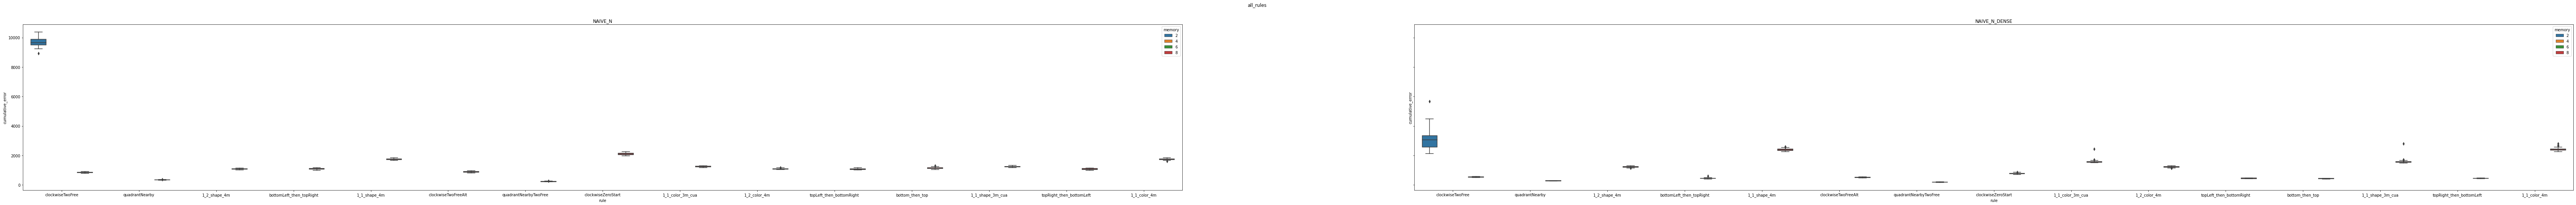

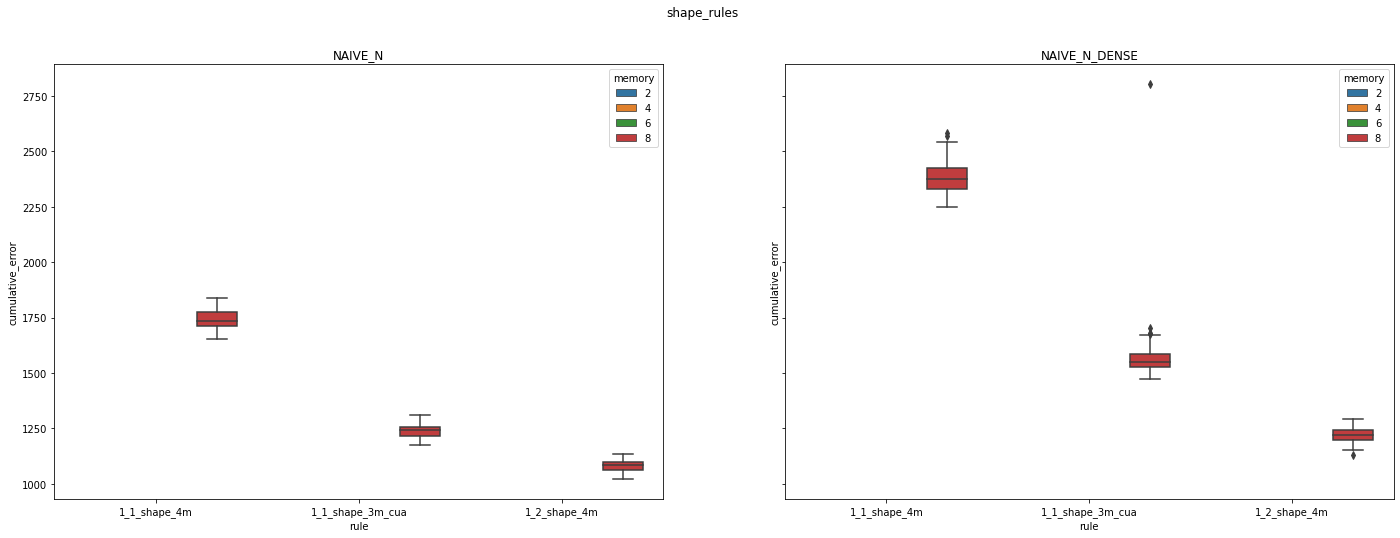

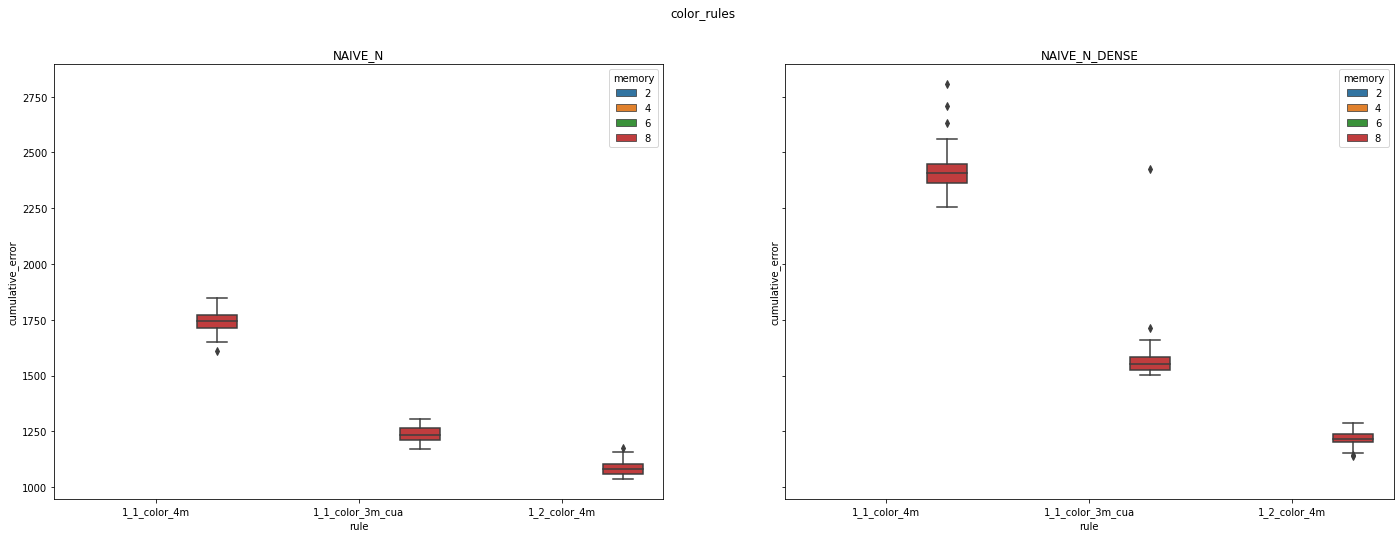

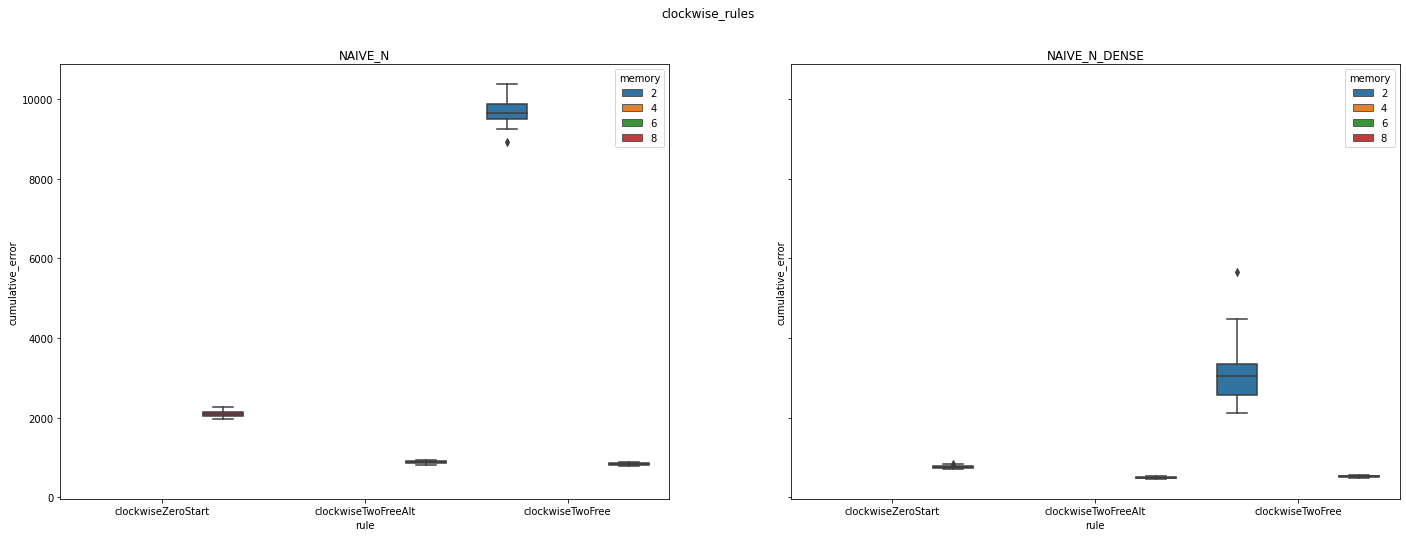

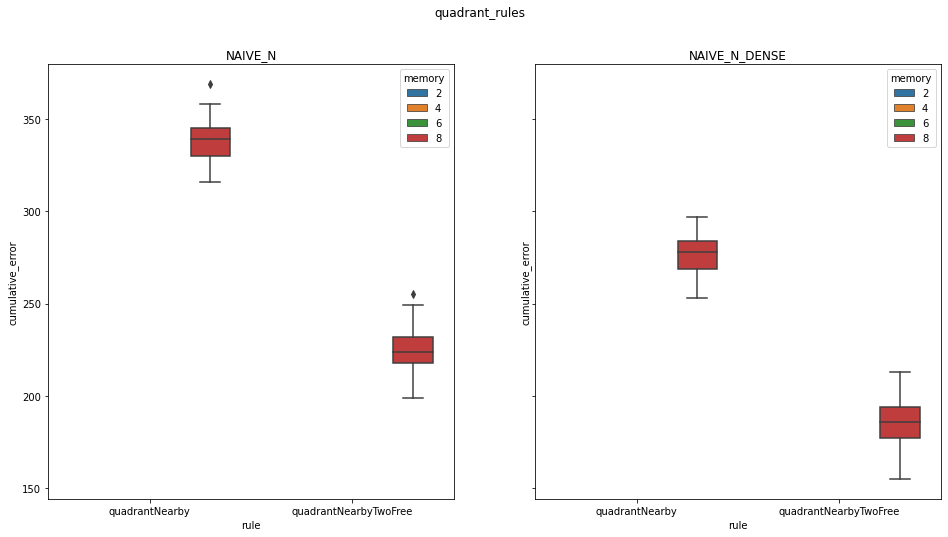

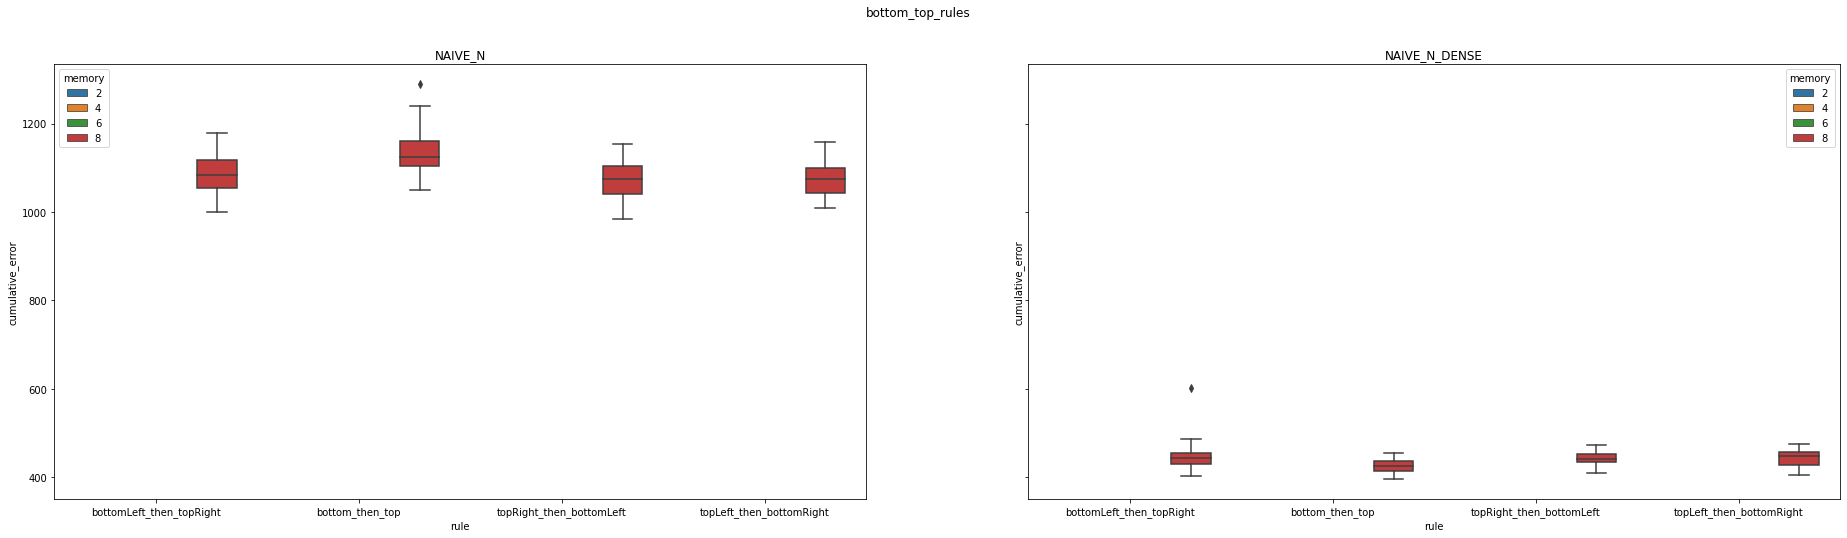

In [7]:
# Create a figure grid
# fig = plt.figure(figsize=(30,35))
# gs = GridSpec(nrows = len(rules_list),ncols=1)
steps=[2,4,6,8]

for i in range(len(rules_list)):
    sub_dict = rules_list[i]
    sub_list = sub_dict["rules"]
    name = sub_dict["name"]
    df1 = terminal_results_df.query("rule in @sub_list and featurization=='NAIVE_N'")
    df2 = terminal_results_df.query("rule in @sub_list and featurization=='NAIVE_N_DENSE'")
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8*len(sub_list),8),sharey=True)
    sns.boxplot(data=df1,ax=ax1,y="cumulative_error",x="rule",hue="memory",order=sub_list,hue_order=steps)
    ax1.set_title('NAIVE_N')
    sns.boxplot(data=df2,ax=ax2,y="cumulative_error",x="rule",hue="memory",order=sub_list,hue_order=steps)
    ax2.set_title('NAIVE_N_DENSE')
    fig.suptitle(name)
    #plt.figure(figsize=(3*len(sub_list),5))
    #g=sns.FacetGrid(data=terminal_results_df.query("rule in @sub_list"),col="featurization")
    #g.map(sns.boxplot,"rule","cumulative_error")
    #sns.boxplot(data=terminal_results_df.query("rule in @sub_list"),y="cumulative_error",x="rule",hue="memory")
    #fig.show()

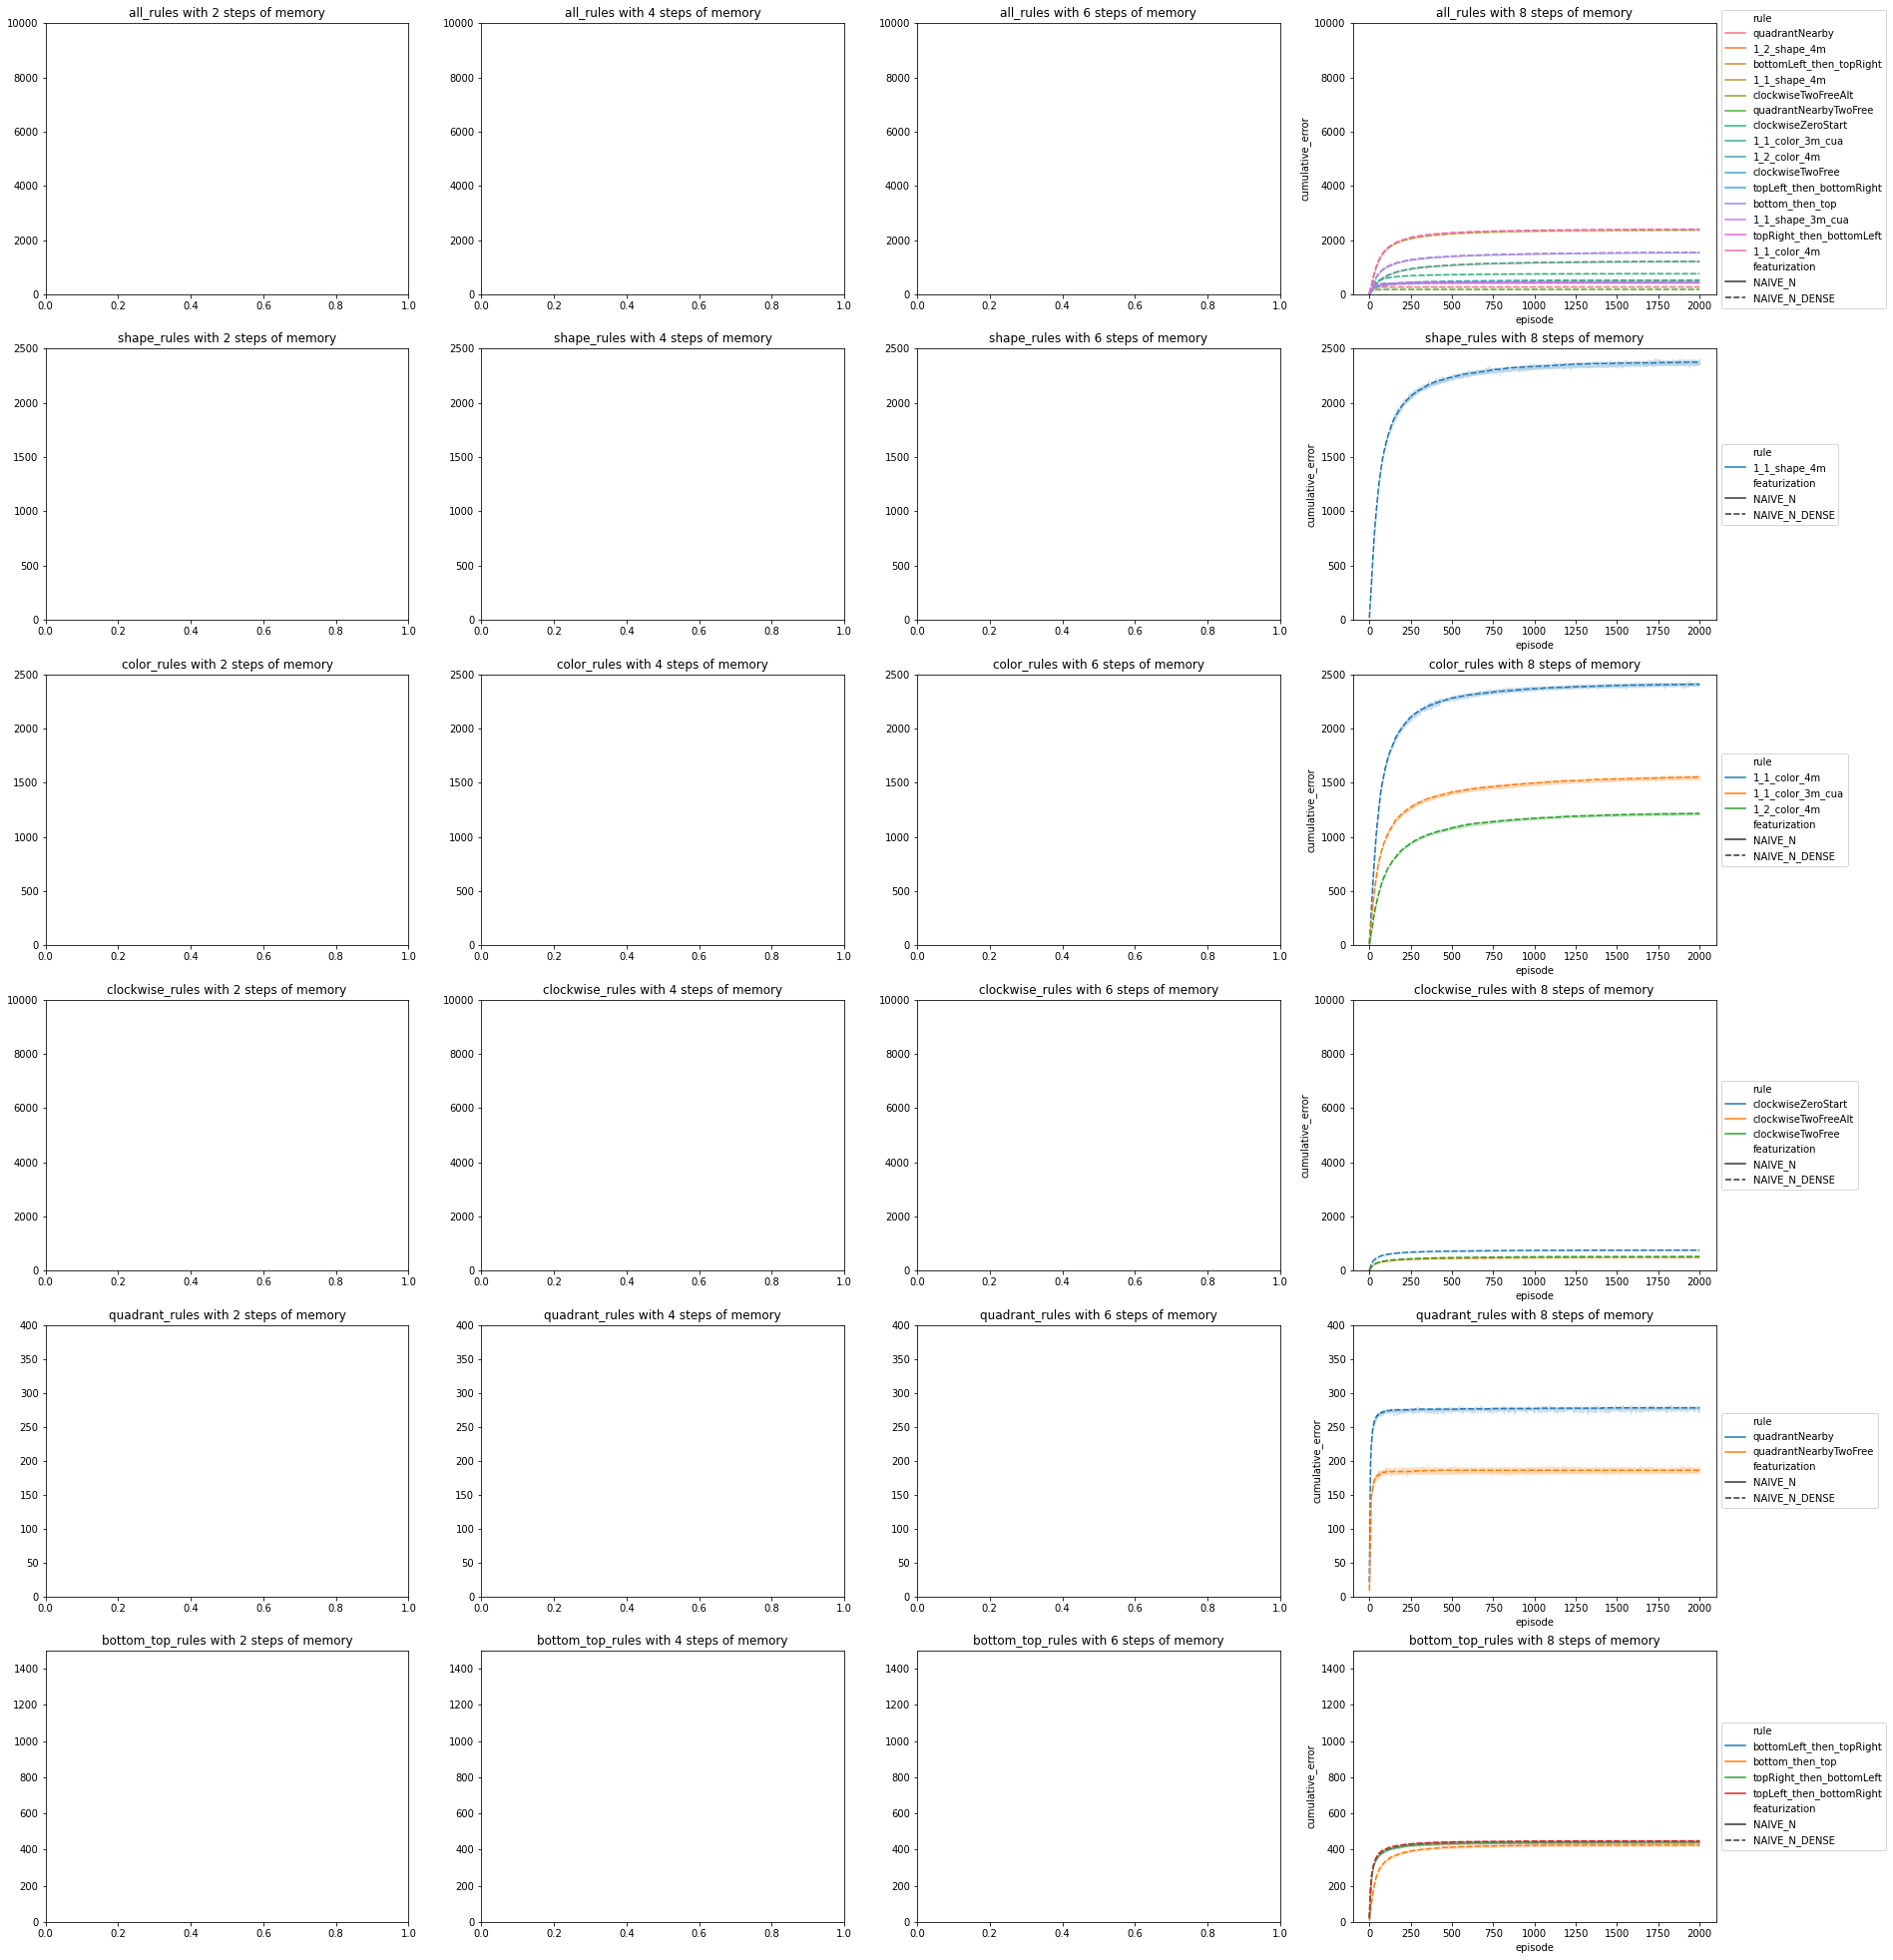

In [5]:
# Create a figure grid
fig = plt.figure(figsize=(30,35))
steps = [2,4,6,8]
#fig = plt.figure(figsize=(5,10))
#steps=[2]
gs = GridSpec(nrows = len(rules_list),ncols=len(steps))

for idx,step in enumerate(steps):
    results_df = episode_results_df[episode_results_df.memory==step]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,idx])
        if not(step==8):
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode", errorbar=("ci",95),estimator=np.median,n_boot=10,hue="rule",hue_order=sub_list,style="featurization",style_order=["NAIVE_N","NAIVE_N_DENSE"],legend=False)
        else:
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode", errorbar=("ci",95),estimator=np.median,n_boot=10,hue="rule",hue_order=sub_list,style="featurization",style_order=["NAIVE_N","NAIVE_N_DENSE"])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(sub_dict["y"])

In [13]:
episode_results_df["trial"]=episode_results_df["trial"].astype("int64")
print(type(test.cumulative_error))

<class 'numpy.float64'>


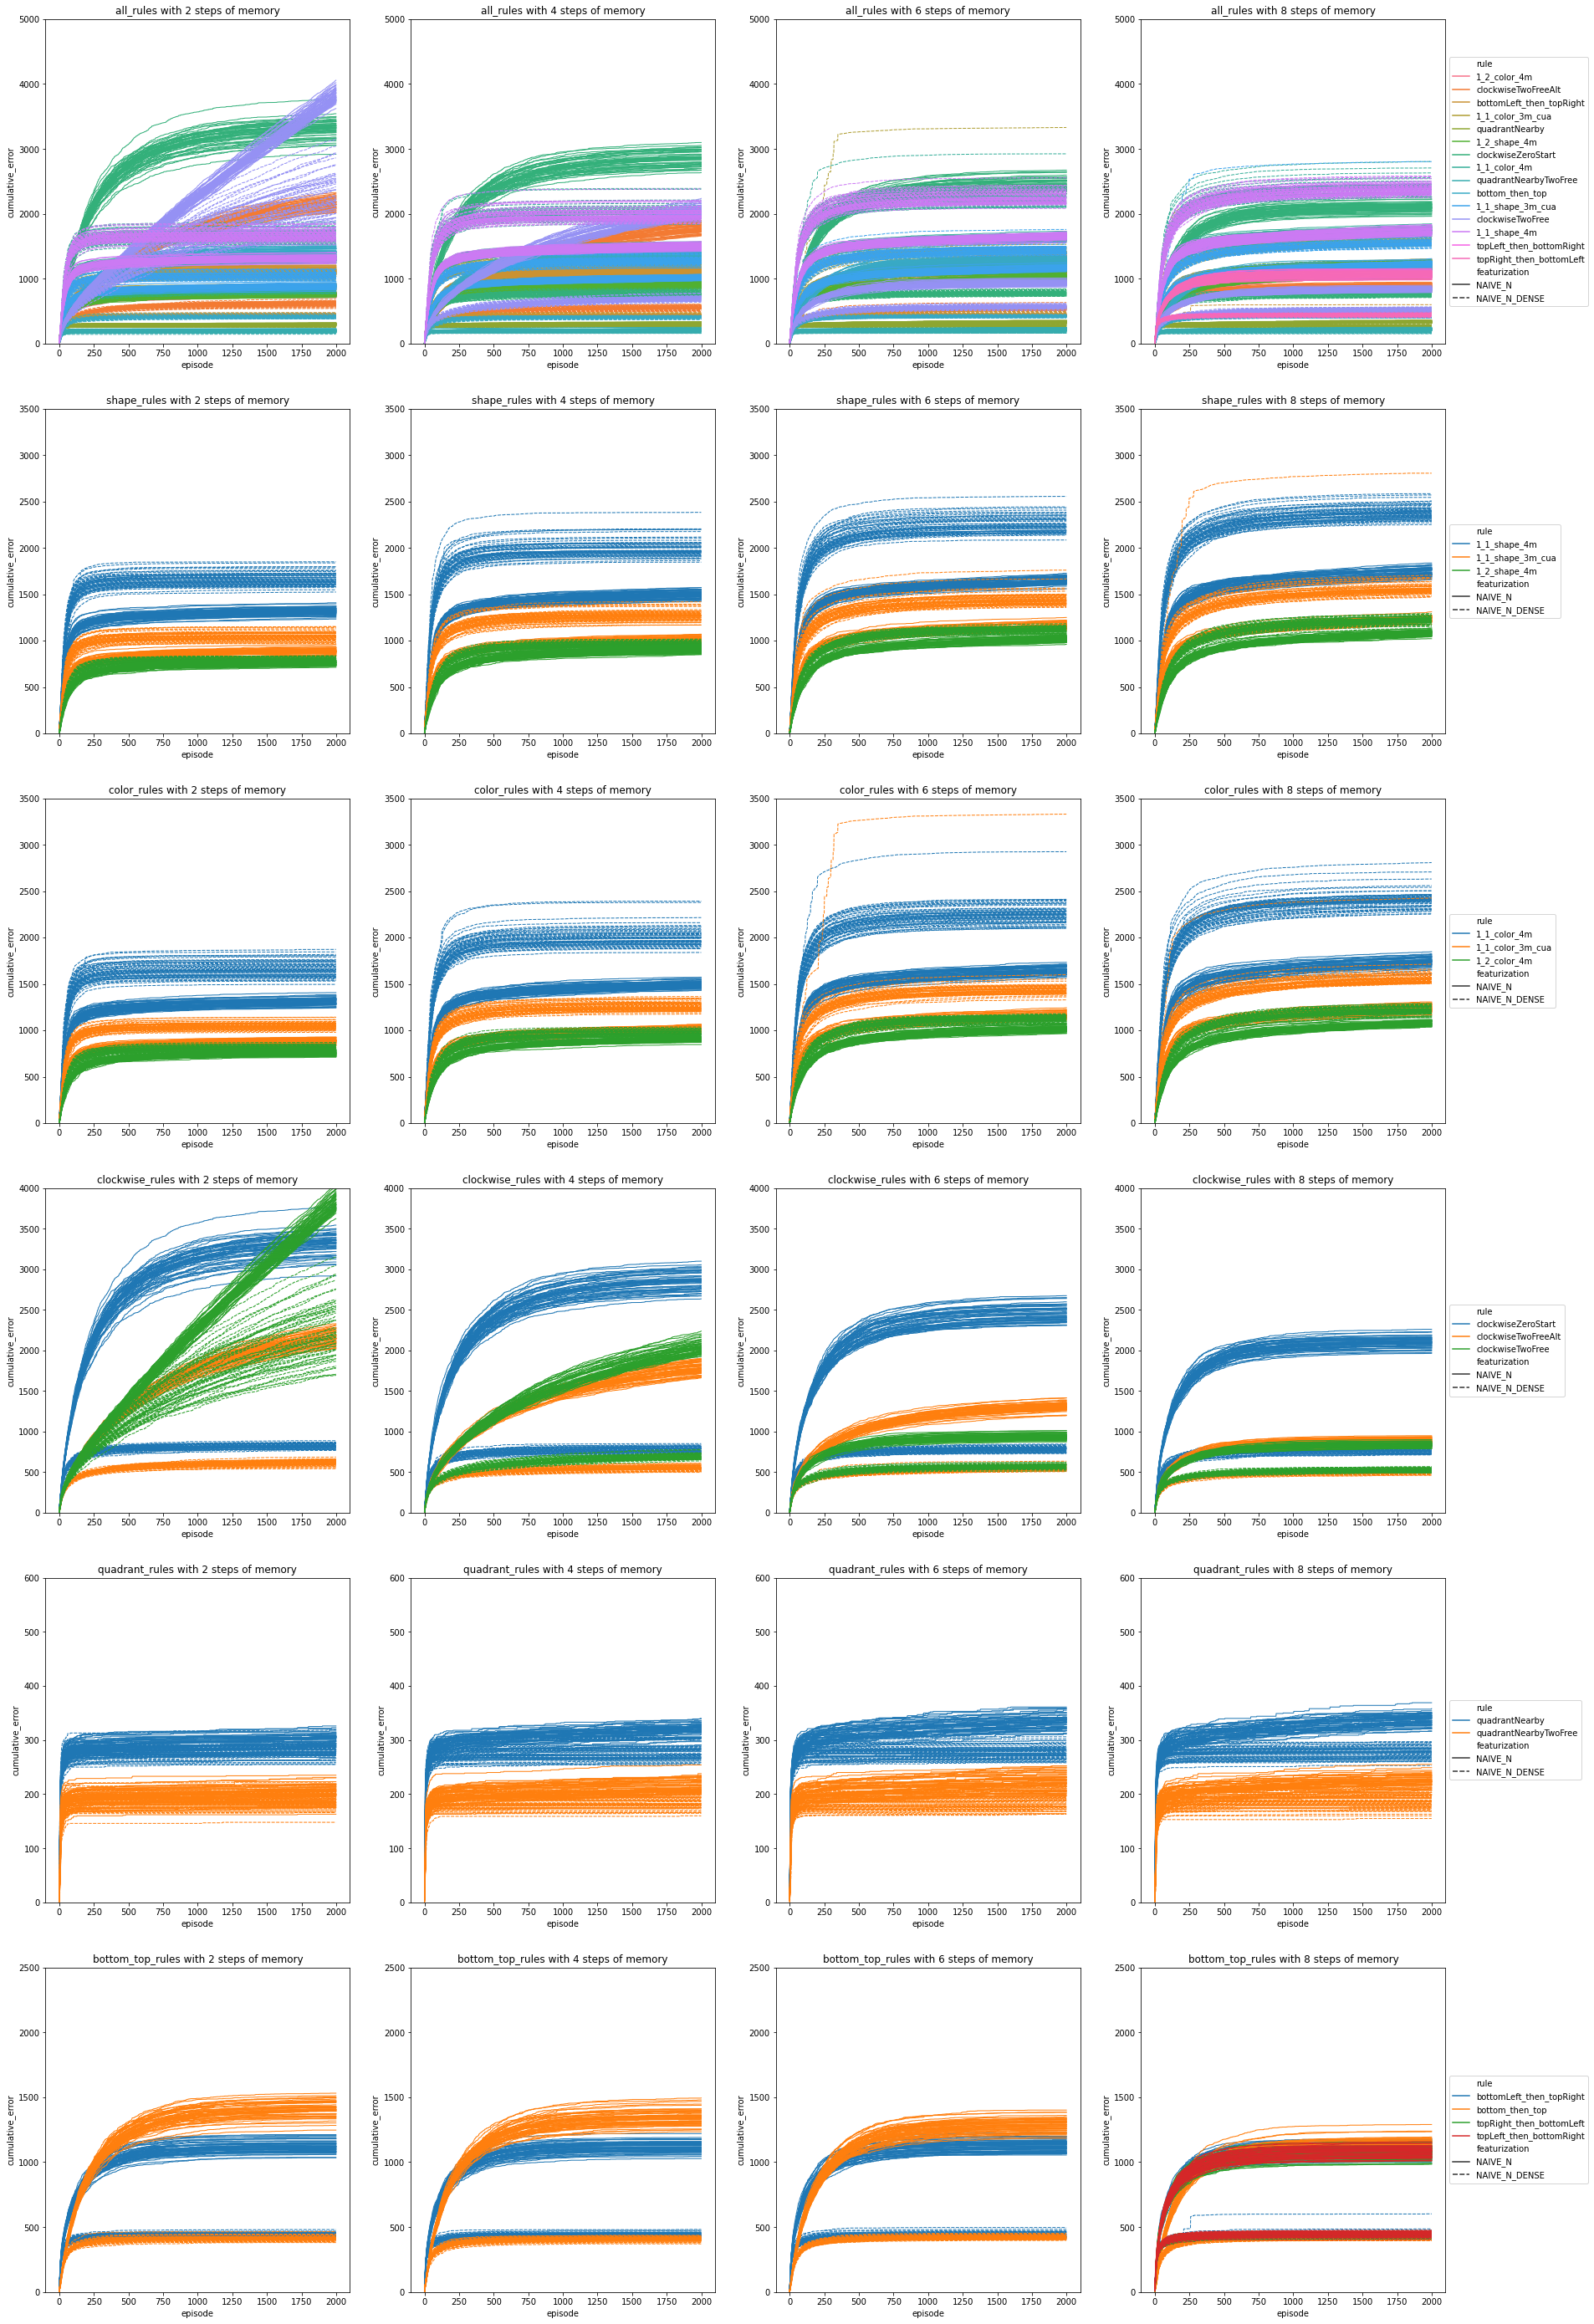

In [31]:
# Create a figure grid
fig = plt.figure(figsize=(30,50))
steps = [2,4,6,8]
#fig = plt.figure(figsize=(5,10))
#steps=[2]
gs = GridSpec(nrows = len(rules_list),ncols=len(steps))

for idx,step in enumerate(steps):
    results_df = episode_results_df[episode_results_df.memory==step]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,idx])
        if not(step==8):
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),linewidth=1,units="trial",y="cumulative_error",x="episode",estimator=None,hue="rule",hue_order=sub_list,style="featurization",style_order=["NAIVE_N","NAIVE_N_DENSE"],legend=False)
        else:
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),linewidth=1,units="trial",y="cumulative_error",x="episode",estimator=None,hue="rule",hue_order=sub_list,style="featurization",style_order=["NAIVE_N","NAIVE_N_DENSE"])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(sub_dict["y"])

In [39]:
debug_df = episode_results_df[episode_results_df.rule=="1_1_color_3m_cua"].copy()
debug_df = debug_df[debug_df.memory==6]
debug_df.head()

,episode,reward,rule,params,memory,experiment_id,trial,featurization,ep_error,cumulative_error
4032000,0,-14.0,1_1_color_3m_cua,initial_run_naive_n6,6,GOH1-232,50,NAIVE_N,14.0,14.0
4032001,1,-15.0,1_1_color_3m_cua,initial_run_naive_n6,6,GOH1-232,50,NAIVE_N,15.0,29.0
4032002,2,-4.0,1_1_color_3m_cua,initial_run_naive_n6,6,GOH1-232,50,NAIVE_N,4.0,33.0
4032003,3,-14.0,1_1_color_3m_cua,initial_run_naive_n6,6,GOH1-232,50,NAIVE_N,14.0,47.0
4032004,4,-11.0,1_1_color_3m_cua,initial_run_naive_n6,6,GOH1-232,50,NAIVE_N,11.0,58.0


In [40]:
debug_df.loc[debug_df.cumulative_error.idxmax()]

episode                         1998
reward                          -1.0
rule                1_1_color_3m_cua
params                initial_run_n6
memory                             6
experiment_id               GOH1-220
trial                             30
featurization          NAIVE_N_DENSE
ep_error                         1.0
cumulative_error              3331.0
Name: 9363998, dtype: object

In [41]:
debug_df_run = debug_df[debug_df.trial==30].copy()
debug_df_run.to_csv("debugging_run.csv")

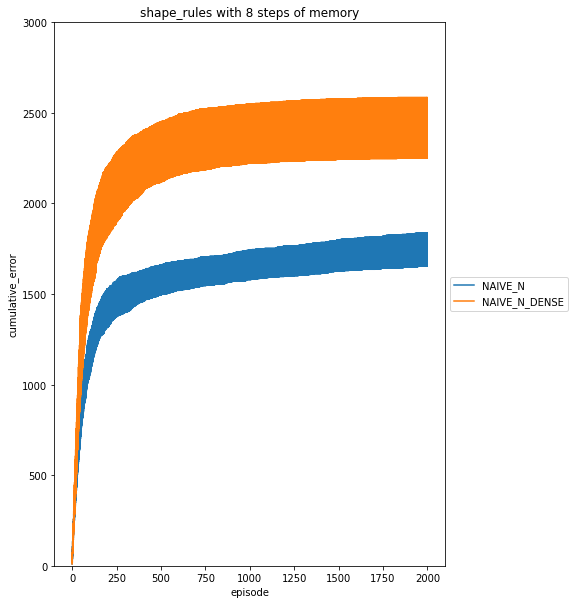

In [17]:
# Create a figure grid
fig = plt.figure(figsize=(7,10))
steps = [8]
#fig = plt.figure(figsize=(5,10))
#steps=[2]
gs = GridSpec(nrows = len(rules_list),ncols=len(steps))

for idx,step in enumerate(steps):
    results_df = episode_results_df[episode_results_df.memory==step]
    for i in range(len(rules_list)):
        sub_dict = rules_list[i]
        sub_list = sub_dict["rules"]
        name = sub_dict["name"]
        ax = fig.add_subplot(gs[i,idx])
        if not(step==8):
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",hue="featurization",estimator=None,hue_order=["NAIVE_N","NAIVE_N_DENSE"],legend=False)
        else:
            ax=sns.lineplot(data=results_df.query("rule in @sub_list"),y="cumulative_error",x="episode",hue="featurization",estimator=None,hue_order=["NAIVE_N","NAIVE_N_DENSE"])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.set_title(name+" with {} steps of memory".format(str(step)))
        ax.set_ylim(sub_dict["y"])